# Imports

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import skimage.io
import seaborn as sn

In [5]:
import tensorflow.python.keras.backend as K

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Treinamento e teste 

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')


test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   color_mode = "rgb",
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle=True)

Found 22968 images belonging to 7 classes.


In [9]:
result = next(train_dataset)

In [10]:
result[0].shape

(64, 48, 48, 3)

In [11]:
teste_y = train_dataset.classes

In [12]:
valid_dataset = train_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 5741 images belonging to 7 classes.


In [13]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 7178 images belonging to 7 classes.


# Construção Modelo

In [14]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [15]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [16]:
custom_model = Sequential()

custom_model.add(Dropout(0.5))
custom_model.add(Flatten())
custom_model.add(BatchNormalization())
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dense(7,activation='softmax'))

In [17]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(custom_model)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 7)                 21191     
Total params: 14,735,879
Trainable params: 19,975
Non-trainable params: 14,715,904
_________________________________________________________________


In [19]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [20]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

In [21]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [32]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('VGG16/model_vgg16.h5')
es = EarlyStopping(verbose=1, patience=20)

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Fit do modelo 

In [25]:
from keras.callbacks import CSVLogger

In [27]:
epochs = 60
batch_size = 64
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = epochs,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60
359/359 [==============================] - 418s 1s/step - loss: 1.9316 - accuracy: 0.8547 - precision: 0.2036 - recall: 0.0058 - auc: 0.5961 - f1_score: 0.0111 - val_loss: 1.8273 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6641 - val_f1_score: 0.0000e+00
Epoch 2/60
359/359 [==============================] - 410s 1s/step - loss: 1.8188 - accuracy: 0.8569 - precision: 0.3233 - recall: 0.0019 - auc: 0.6486 - f1_score: 0.0037 - val_loss: 1.7787 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 3.4837e-04 - val_auc: 0.6792 - val_f1_score: 6.8376e-04
Epoch 3/60
359/359 [==============================] - 411s 1s/step - loss: 1.7955 - accuracy: 0.8568 - precision: 0.3590 - recall: 0.0030 - auc: 0.6638 - f1_score: 0.0060 - val_loss: 1.7629 - val_accuracy: 0.8573 - val_precision: 0.6923 - val_recall: 0.0016 - val_auc: 0.6851 - val_f1_score: 0.0031
Epoch 4/60
359/359 [==============================] - 411s 1s/step - loss: 1.7779 -

359/359 [==============================] - 391s 1s/step - loss: 1.7177 - accuracy: 0.8576 - precision: 0.5569 - recall: 0.0160 - auc: 0.7094 - f1_score: 0.0308 - val_loss: 1.7049 - val_accuracy: 0.8572 - val_precision: 0.6000 - val_recall: 0.0010 - val_auc: 0.7189 - val_f1_score: 0.0020
Epoch 29/60
359/359 [==============================] - 391s 1s/step - loss: 1.7194 - accuracy: 0.8579 - precision: 0.5805 - recall: 0.0179 - auc: 0.7081 - f1_score: 0.0343 - val_loss: 1.7017 - val_accuracy: 0.8573 - val_precision: 0.7222 - val_recall: 0.0023 - val_auc: 0.7223 - val_f1_score: 0.0044
Epoch 30/60
359/359 [==============================] - 391s 1s/step - loss: 1.7219 - accuracy: 0.8575 - precision: 0.5408 - recall: 0.0179 - auc: 0.7070 - f1_score: 0.0343 - val_loss: 1.7000 - val_accuracy: 0.8573 - val_precision: 0.7222 - val_recall: 0.0023 - val_auc: 0.7210 - val_f1_score: 0.0046
Epoch 31/60
359/359 [==============================] - 391s 1s/step - loss: 1.7194 - accuracy: 0.8574 - precisio

359/359 [==============================] - 389s 1s/step - loss: 1.7190 - accuracy: 0.8579 - precision: 0.5909 - recall: 0.0181 - auc: 0.7092 - f1_score: 0.0349 - val_loss: 1.6944 - val_accuracy: 0.8573 - val_precision: 0.7500 - val_recall: 0.0021 - val_auc: 0.7260 - val_f1_score: 0.0041
Epoch 56/60
359/359 [==============================] - 389s 1s/step - loss: 1.7153 - accuracy: 0.8574 - precision: 0.5334 - recall: 0.0163 - auc: 0.7101 - f1_score: 0.0314 - val_loss: 1.6934 - val_accuracy: 0.8574 - val_precision: 0.7778 - val_recall: 0.0024 - val_auc: 0.7254 - val_f1_score: 0.0048
Epoch 57/60
359/359 [==============================] - 390s 1s/step - loss: 1.7177 - accuracy: 0.8575 - precision: 0.5392 - recall: 0.0171 - auc: 0.7099 - f1_score: 0.0328 - val_loss: 1.7004 - val_accuracy: 0.8571 - val_precision: 0.5000 - val_recall: 1.7419e-04 - val_auc: 0.7220 - val_f1_score: 3.4188e-04
Epoch 58/60
359/359 [==============================] - 390s 1s/step - loss: 1.7142 - accuracy: 0.8576 - 

## Salvando o history em json

In [28]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'VGG16/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    

## Salvando o modelo

In [29]:
custom_model.save("VGG16/custom_model")

INFO:tensorflow:Assets written to: VGG16/custom_model/assets


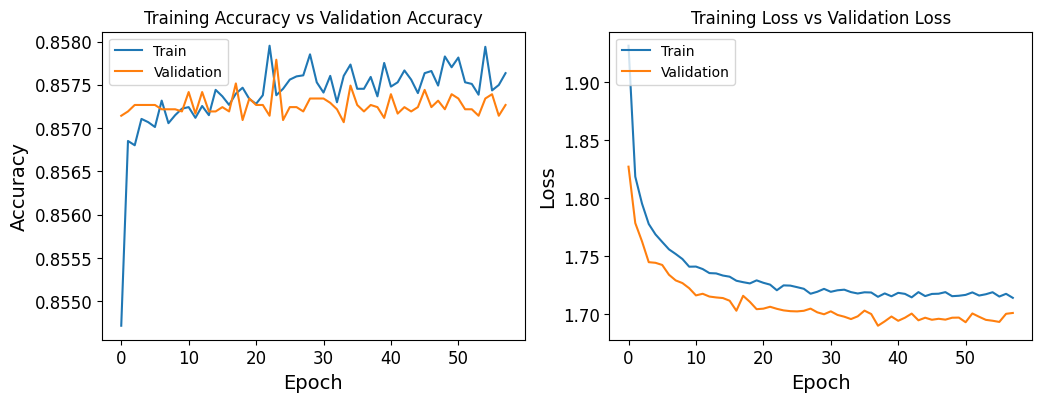

In [30]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_l = history.history['val_accuracy']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Evaluate 

In [31]:
results = model.evaluate(test_dataset, batch_size=64)

113/113 [==============================] - 96s 849ms/step - loss: 1.6706 - accuracy: 0.8575 - precision: 0.6349 - recall: 0.0056 - auc: 0.7361 - f1_score: 0.0108
